***
# <center><font color=blue> **ALTEGRAD - Challenge**</font></center>
# <center><font color=red> **Can you predict whether two short texts have the same meaning?**</font></center>
***
#### <center>Alexis Blanchet --- Team Alexis </center> 

## Imports 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
import distance
from collections import defaultdict
import networkx as nx
from sklearn.metrics import log_loss
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import HashingVectorizer
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from nltk import word_tokenize, ngrams
import scipy as scipy

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import progressbar
from sklearn.model_selection import train_test_split
from collections import Counter

C:\Users\Alexis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## 1 Features Extraction
### 1.1 Loading the data

In [3]:
# Load from csv files
train = pd.read_csv('data/train.csv',names=['id','idq1','idq2','q1','q2','is_same'])
test = pd.read_csv('data/test.csv',names=['id','idq1','idq2','q1','q2'])

# Visualize head of DataFrame
train.head(5)

,id,idq1,idq2,q1,q2,is_same
0,0,199954,384085,What are the some of the best novels?,What are some of the greatest novels of all ti...,0
1,1,128681,237407,What are the pictures that made you look twice?,What are some amazing pictures one has to see ...,0
2,2,170846,240621,Have the ellectoral college members ever voted...,When has the electoral college voted against t...,1
3,3,55110,177468,Did Ravana really have 10 heads?,Why did Ravana have 10 heads?,1
4,4,425513,400256,What's a book that you feel helped you to impr...,What books or magazines should I read to impro...,0


### 1.2 NLP Features

In [4]:
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

In [5]:

def preprocess(x):
    #Normalization of the questions to avoid spoken habits
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x


def get_ngram_features(que1,que2):
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in que1.lower().split() if word not in STOP_WORDS]
    unigrams_que2 = [word for word in que2.lower().split() if word not in STOP_WORDS]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    out_list.append(common_unigrams_len)
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.append(common_unigrams_ratio)

    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.append(common_bigrams_len)
    out_list.append(common_bigrams_ratio)

    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.append(common_trigrams_len)
    out_list.append(common_trigrams_ratio)
    return out_list

def get_ngram_features_stem(que1,que2):
    que1 =" ".join([ps.stem(w) for w in word_tokenize(que1)])
    que2 = " ".join([ps.stem(w) for w in word_tokenize(que2)])
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in que1.lower().split() if word not in STOP_WORDS]
    unigrams_que2 = [word for word in que2.lower().split() if word not in STOP_WORDS]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    out_list.append(common_unigrams_len)
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.append(common_unigrams_ratio)

    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.append(common_bigrams_len)
    out_list.append(common_bigrams_ratio)

    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.append(common_trigrams_len)
    out_list.append(common_trigrams_ratio)
    return out_list



def get_token_features(q1, q2):
    l1 = " ".join([ps.stem(w) for w in word_tokenize(q1)])
    l2 = " ".join([ps.stem(w) for w in word_tokenize(q2)])
    
    token_features = [0.0]*20

    
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])    
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))   
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    q1_tokens = l1.split()
    q2_tokens = l2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])    
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))   
    
    
    token_features[10] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[11] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[12] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[13] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[14] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[15] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[16] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[17] = int(q1_tokens[0] == q2_tokens[0])
    token_features[18] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[19] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(q1,q2):
    vectorizer = CountVectorizer()
    vectorizer.fit([q1,q2])
    return vectorizer.transform(q1),vectorizer.transform(q2)

def get_cosine(q1,q2):
    vector1,vector2 = text_to_vector(q1,q2)
    return get_cosine(vector1, vector2)

def get_hamming(q1,q2):
    return scipy.spatial.distance.hamming(q1,q2)

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
    
def extract_features(df):      
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    print("Distance features ")
    
    #df["cosine_distance"] = df.apply(lambda x: get_cosine(str(x["question1"]), str(x["question2"])), axis=1)
    df["hamming_distance"] = df.apply(lambda x: get_hamming(x["question1"], x["question2"]), axis=1)

    print("token features")
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    df["cwc_min_stem"]       = list(map(lambda x: x[10], token_features))
    df["cwc_max_stem"]       = list(map(lambda x: x[11], token_features))
    df["csc_min_stem"]       = list(map(lambda x: x[12], token_features))
    df["csc_max_stem"]       = list(map(lambda x: x[13], token_features))
    df["ctc_min_stem"]       = list(map(lambda x: x[14], token_features))
    df["ctc_max_stem"]       = list(map(lambda x: x[15], token_features))
    df["last_word_eq_stem"]  = list(map(lambda x: x[16], token_features))
    df["first_word_eq_stem"] = list(map(lambda x: x[17], token_features))
    df["abs_len_diff_stem"]  = list(map(lambda x: x[18], token_features))
    df["mean_len_stem"]      = list(map(lambda x: x[19], token_features))


    print("fuzzy features")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    print("ngram features ")
    
    ngram_features = df.apply(lambda row: get_ngram_features(str(row['question1']), str(row['question2'])), axis=1)
    df["unigrams_len"]   = list(map(lambda x: x[0], ngram_features))
    df["unigrams_ratio"] = list(map(lambda x: x[1], ngram_features))
    df["bigrams_len"]    = list(map(lambda x: x[2], ngram_features))
    df["bigrams_ratio"]  = list(map(lambda x: x[3], ngram_features))
    df["trigrams_len"]   = list(map(lambda x: x[4], ngram_features))
    df["trigrams_ratio"] = list(map(lambda x: x[5], ngram_features))
    
    ngram_features = df.apply(lambda row: get_ngram_features_stem(str(row['question1']), str(row['question2'])), axis=1)
    df["unigrams_len_stem"]   = list(map(lambda x: x[0], ngram_features))
    df["unigrams_ratio_stem"] = list(map(lambda x: x[1], ngram_features))
    df["bigrams_len_stem"]    = list(map(lambda x: x[2], ngram_features))
    df["bigrams_ratio_stem"]  = list(map(lambda x: x[3], ngram_features))
    df["trigrams_len_stem"]   = list(map(lambda x: x[4], ngram_features))
    df["trigrams_ratio_stem"] = list(map(lambda x: x[5], ngram_features))
    

    return df


print("--Preparation for Extraction--")
ps = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')


print("Extracting features for train:")
train_df = pd.read_csv("data/train.csv",names =["id", "qid1", "qid2", "question1", "question2", "labels"] )
train_df = extract_features(train_df)
train_df.drop(["id", "qid1", "qid2", "question1", "question2", "labels"], axis=1, inplace=True)
train_df.to_csv("features/nlp_features_train.csv", index=False)

print("Extracting features for test:")

test_df = pd.read_csv("data/test.csv",names = ["test_id", "qid1", "qid2", "question1", "question2"])
test_df = extract_features(test_df)
test_df.drop(["test_id", "qid1", "qid2", "question1", "question2"], axis=1, inplace=True)
test_df.to_csv("features/nlp_features_test.csv", index=False)

--Preparation for Extraction--
Extracting features for train:
Distance features 
token features
fuzzy features
ngram features 
Extracting features for test:
Distance features 
token features
fuzzy features
ngram features 


### 1.3 Structural Features

In [6]:
NEIGHBOR_UPPER_BOUND = 20
NB_CORES = 5
FREQ_UPPER_BOUND = 150

In [7]:
def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0


print("---Extracting Question Hash Features---")
train_df = pd.read_csv("data/train.csv",names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"] )
test_df = pd.read_csv("data/test.csv",names = ["id_test", "qid1", "qid2", "question1", "question2"])

## put all questions together and build a new Data Frame
df1 = train_df[['question1']].copy()
df2 = train_df[['question2']].copy()
df1_test = test_df[['question1']].copy()
df2_test = test_df[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_df.copy()
test_cp = test_df.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'id_test':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])


comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()


#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = pd.DataFrame(comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']])
test_comb = pd.DataFrame(comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']])


train_comb.drop(['id','is_duplicate'],axis = 1,inplace = True)
test_comb.drop(['id'],axis = 1,inplace = True)
print(train_comb.columns)
train_comb.to_csv('features/train_hash.csv',index=False)
test_comb.to_csv('features/test_hash.csv',index=False)

---Extracting Question Hash Features---
Index(['q1_hash', 'q2_hash', 'q1_freq', 'q2_freq'], dtype='object')


In [8]:
def create_question_hash(train_df, test_df):
    train_qs = np.dstack([train_df["question1"], train_df["question2"]]).flatten()
    test_qs = np.dstack([test_df["question1"], test_df["question2"]]).flatten()
    all_qs = np.append(train_qs, test_qs)
    all_qs = pd.DataFrame(all_qs)[0].drop_duplicates()
    all_qs.reset_index(inplace=True, drop=True)
    question_dict = pd.Series(all_qs.index.values, index=all_qs.values).to_dict()
    return question_dict


def get_hash(df, hash_dict):
    df["qid1"] = df["question1"].map(hash_dict)
    df["qid2"] = df["question2"].map(hash_dict)
    return df.drop(["question1", "question2"], axis=1)


def get_kcore_dict(df):
    g = nx.Graph()
    g.add_nodes_from(df.qid1)
    edges = list(df[["qid1", "qid2"]].to_records(index=False))
    g.add_edges_from(edges)
    g.remove_edges_from(g.selfloop_edges())

    df_output = pd.DataFrame(data=g.nodes(), columns=["qid"])
    df_output["kcore"] = 0
    for k in range(2, NB_CORES + 1):
        ck = nx.k_core(g, k=k).nodes()
        print("kcore", k)
        df_output.ix[df_output.qid.isin(ck), "kcore"] = k

    return df_output.to_dict()["kcore"]


def get_kcore_features(df, kcore_dict):
    df["kcore1"] = df["qid1"].apply(lambda x: kcore_dict[x])
    df["kcore2"] = df["qid2"].apply(lambda x: kcore_dict[x])
    return df


def convert_to_minmax(df, col):
    sorted_features = np.sort(np.vstack([df[col + "1"], df[col + "2"]]).T)
    df["min_" + col] = sorted_features[:, 0]
    df["max_" + col] = sorted_features[:, 1]
    return df.drop([col + "1", col + "2"], axis=1)


def get_neighbors(train_df, test_df):
    neighbors = defaultdict(set)
    for df in [train_df, test_df]:
        for q1, q2 in zip(df["qid1"], df["qid2"]):
            neighbors[q1].add(q2)
            neighbors[q2].add(q1)
    return neighbors

def get_neighbors_of_neighbors(train_df,test_df):
    nofn = defaultdict(set)
    n = get_neighbors(train_df,test_df)
    for q in n:
        for p in n[q]:
            nofn[q].add(p)
    return nofn

def get_neighbor_features(df, neighbors,nn):
    common_nc = df.apply(lambda x: len(neighbors[x.qid1].intersection(neighbors[x.qid2])), axis=1)
    min_nc = df.apply(lambda x: min(len(neighbors[x.qid1]), len(neighbors[x.qid2])), axis=1)
    df["common_neighbor_ratio"] = common_nc / min_nc
    df["common_neighbor_count"] = common_nc.apply(lambda x: min(x, NEIGHBOR_UPPER_BOUND))
    common_nc = df.apply(lambda x: len(nn[x.qid1].intersection(nn[x.qid2])), axis=1)
    min_nc = df.apply(lambda x: min(len(nn[x.qid1]), len(nn[x.qid2])), axis=1)
    df["common_nofn_ratio"] = common_nc / min_nc
    df["common_nofn_count"] = common_nc.apply(lambda x: min(x, NEIGHBOR_UPPER_BOUND))
    return df

def get_pagerank_dic(train_df,test_df):
    g = nx.Graph()
    g.add_nodes_from(train_df.question1)
    g.add_nodes_from(train_df.question2)
    g.add_nodes_from(test_df.question1)
    g.add_nodes_from(test_df.question2)

    g.add_edges_from(train_df[['question1', 'question2']].to_records(index=False))
    g.add_edges_from(test_df[['question1', 'question2']].to_records(index=False))

    d = nx.pagerank(g)
    return d

def get_graph(train_df,test_df):
    g = nx.Graph()
    g.add_nodes_from(train_df.question1)
    g.add_nodes_from(train_df.question2)
    g.add_nodes_from(test_df.question1)
    g.add_nodes_from(test_df.question2)

    g.add_edges_from(train_df[['question1', 'question2']].to_records(index=False))
    g.add_edges_from(test_df[['question1', 'question2']].to_records(index=False))
    return g
def get_shortest_path(g,q1,q2):
    q = g
    q.remove_edge(q1,q2)
    try:res = len(nx.shortest_path(q,q1,q2))
    except: res= 1000
    return res
     
def get_shortest_path_features(df,g):
    l = []
    for index, (q1, q2) in enumerate(zip(df["question1"], df["question2"])):
        l.append(get_shortest_path(g,q1,q2))
    df["Shortest_path"] = l
    return df

def get_pagerank_features(df, d):
    pagerank_ratio = df.apply(lambda x: d[x[3]]/d[x[4]],axis=1)
    df["pagerank_ratio"] = pagerank_ratio.apply(lambda x: min(x,100))
    return df


def get_freq_features(df, frequency_map):
    df["freq1"] = df["qid1"].map(lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    df["freq2"] = df["qid2"].map(lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    return df

def clique(df_tr,df_te):
    G = nx.Graph()
    df =pd.concat([df_tr.iloc[:, :-1], df_te], ignore_index = True)
    edges = [tuple(x) for x in df[['question1', 'question2']].values]
    G.add_edges_from(edges)
    return G

def clique_features(df,G):
    if 'is_duplicate' in df.columns.values:
        map_label = dict(((x[0], x[1]),x[2]) for x in df[['question1', 'question2','is_duplicate']].values)
    else:
         map_label = dict(((x[0], x[1]),0) for x in df[['question1', 'question2']].values)
    map_clique_size = {}
    cliques = sorted(list(nx.find_cliques(G)), key=lambda x: len(x))
    for cli in cliques:
        for q1, q2 in combinations(cli, 2):
            if (q1, q2) in map_label:
                map_clique_size[q1, q2] = len(cli)
            elif (q2, q1) in map_label:
                map_clique_size[q2, q1] = len(cli)

    df['clique_size'] = df.apply(lambda row: map_clique_size.get((row['question1'], row['question2']), -1), axis=1)
    return df

train_df = pd.read_csv("data/train.csv",names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"] )
test_df = pd.read_csv("data/test.csv",names = ["id_test", "qid1", "qid2", "question1", "question2"])

print("Calculating clique features")
G = clique(train_df,test_df)
train_df = clique_features(train_df, G)
test_df = clique_features(test_df, G)

print("Calculating Shortest Path Features")
g = get_graph(train_df,test_df)
train_df = get_shortest_path_features(train_df, g)
test_df = get_shortest_path_features(test_df, g) 

print("Calculating pagerank ratio...")
d = get_pagerank_dic(train_df, test_df)
train_df = get_pagerank_features(train_df, d)
test_df = get_pagerank_features(test_df, d) 

print("Hashing the questions...")
question_dict = create_question_hash(train_df, test_df)
train_df = get_hash(train_df, question_dict)
test_df = get_hash(test_df, question_dict)
print("Number of unique questions:", len(question_dict))

print("Calculating kcore features...")
all_df = pd.concat([train_df, test_df])
kcore_dict = get_kcore_dict(all_df)
train_df = get_kcore_features(train_df, kcore_dict)
test_df = get_kcore_features(test_df, kcore_dict)
train_df = convert_to_minmax(train_df, "kcore")
test_df = convert_to_minmax(test_df, "kcore")

print("Calculating common neighbor features...")
neighbors = get_neighbors(train_df, test_df)
nn = get_neighbors_of_neighbors(train_df,test_df)
train_df = get_neighbor_features(train_df, neighbors,nn)
test_df = get_neighbor_features(test_df, neighbors,nn)

print("Calculating frequency features...")
frequency_map = dict(zip(*np.unique(np.vstack((all_df["qid1"], all_df["qid2"])), return_counts=True)))
train_df = get_freq_features(train_df, frequency_map)
test_df = get_freq_features(test_df, frequency_map)
train_df = convert_to_minmax(train_df, "freq")
test_df = convert_to_minmax(test_df, "freq")


cols = ["min_kcore", "max_kcore","Shortest_path","common_nofn_ratio","common_nofn_count", "common_neighbor_count", "common_neighbor_ratio", "min_freq", "max_freq","pagerank_ratio",'clique_size']
train_df.loc[:, cols].to_csv("features/non_nlp_features_train.csv", index=False)
test_df.loc[:, cols].to_csv("features/non_nlp_features_test.csv", index=False)

Calculating clique features
Calculating Shortest Path Features
Calculating pagerank ratio...
Hashing the questions...
Number of unique questions: 58869
Calculating kcore features...
kcore 2
kcore 3
kcore 4
kcore 5
Calculating common neighbor features...
Calculating frequency features...


In [9]:
trdf = pd.read_csv('data/train.csv',names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"]).iloc[:, :-1]
tedf = pd.read_csv('data/test.csv',names = ["id_test", "qid1", "qid2", "question1", "question2"])

tr = pd.concat([trdf, tedf], ignore_index = True)

g = nx.Graph()
g.add_nodes_from(tr.question1)
g.add_nodes_from(tr.question2)
edges = list(tr[['question1', 'question2']].to_records(index=False))
g.add_edges_from(edges)

print('Number of unique questions:', len(set(tr.question1) | set(tr.question2)), g.number_of_nodes())
print('Number of rows in the data:', len(tr), g.number_of_edges())

d = g.degree()
print('Mean number of connections:', np.mean([d[k] for k in d]))

def create_q_interactions(name):
    comb['min_'+name] = comb[['q1_'+name, 'q2_'+name]].min(1)
    comb['max_'+name] = comb[['q1_'+name, 'q2_'+name]].max(1)
    comb['mean_'+name] = comb[['q1_'+name, 'q2_'+name]].mean(1)
    comb['sum_'+name] = comb['q1_'+name] + comb['q2_'+name]
    comb['diff_'+name] = abs(comb['q1_'+name] - comb['q2_'+name])

comb = pd.DataFrame()

comb['q1_neighbor_count'] = tr['question1'].map(g.neighbors).map(len)
comb['q2_neighbor_count'] = tr['question2'].map(g.neighbors).map(len)
create_q_interactions('neighbor_count')
comb['shared_neighbor_count'] = tr[['question1', 'question2']].apply(
    lambda x: nx.common_neighbors(g, x.question1, x.question2), 1).apply(lambda x: sum(1 for _ in x))
comb_tr = comb.iloc[:trdf.shape[0], :]
comb_te = comb.iloc[trdf.shape[0]:, :]
comb_te = comb_te.reset_index(drop=True)

comb_tr.to_csv('features/train_network_neighbors.csv', index=False)
comb_te.to_csv('features/test_network_neighbors.csv', index=False)

Number of unique questions: 58869 58869
Number of rows in the data: 100279 100279
Mean number of connections: 3.40685250302


### 1.4 Embedded Features

In [13]:
import gensim
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from tqdm import tqdm

In [14]:
 model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz',binary=True)

In [32]:
SAFE_DIV = 0.0001

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in STOP_WORDS]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

def embeded_features(data):
    question1_vectors = np.zeros((data.shape[0], 300))
    error_count = 0

    for i, q in tqdm(enumerate(data.question1.values)):
        question1_vectors[i, :] = sent2vec(q)

    question2_vectors  = np.zeros((data.shape[0], 300))
    for i, q in tqdm(enumerate(data.question2.values)):
        question2_vectors[i, :] = sent2vec(q)
    
    print("data processed")
    data['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
    data['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
    data['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
    data['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]
    
    data["skew_ratio"]=data.apply(lambda x: min(x['skew_q1vec']/(x['skew_q2vec']+SAFE_DIV),x['skew_q2vec']/(x['skew_q1vec']+SAFE_DIV)),axis=1)
    data["kur_ratio"]=data.apply(lambda x: min(x['kur_q1vec']/(x['kur_q2vec']+SAFE_DIV),x['kur_q2vec']/(x['kur_q1vec']+SAFE_DIV)),axis=1)
    
    data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    
        
    print("features created")
    
    return data.drop(["question1", "question2"],axis=1)

train_df = pd.read_csv("data/train.csv",names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"] )
test_df = pd.read_csv("data/test.csv",names = ["id_test", "qid1", "qid2", "question1", "question2"])

print("Calculating train embeded features")
embeded_features(train_df.drop(["id", "qid1", "qid2","is_duplicate"],axis=1)).to_csv("features/train_embeded_features.csv",index=False)

print("Calculating test embeded features")
embeded_features(test_df.drop(["id_test", "qid1", "qid2"],axis=1)).to_csv("features/test_embeded_features.csv",index=False)

Calculating train embeded features


80100it [00:13, 5962.80it/s]
80100it [00:13, 6116.32it/s]


data processed
features created
Calculating test embeded features


20179it [00:11, 1747.76it/s]
20179it [00:09, 2153.78it/s]


data processed
features created


### 1.5 Feature Augmentation 

In [33]:
def cartprod(X,Y):
    cols1 = X.columns
    cols2 = Y.columns
    X_ = pd.DataFrame()
    for col1 in cols1:
        for col2 in cols2:
            #print(col1+"x"+col2)
            X_[col1+"x"+col2]=X[col1]*Y[col2]
    return X_
        

In [34]:
print("Train features are being merged")

train_groupe_1 = pd.read_csv("features/nlp_features_train.csv")
train_groupe_2 = pd.read_csv('features/train_hash.csv')
train_groupe_3 = pd.read_csv("features/non_nlp_features_train.csv")
train_groupe_4 = pd.read_csv('features/train_network_neighbors.csv')
train_groupe_5 = pd.read_csv('features/train_embeded_features.csv').fillna(0)

X_train = np.hstack((train_groupe_1 ,train_groupe_2 ,train_groupe_3,train_groupe_4,train_groupe_5))
C_train = cartprod(train_groupe_1,train_groupe_3.join(train_groupe_4).join(train_groupe_2))
X_train_all = np.hstack((X_train,C_train))
print(X_train.shape)

Train features are being merged
(80100, 74)


In [35]:
print("Test features are being merged")

test_groupe_1 = pd.read_csv("features/nlp_features_test.csv")
test_groupe_2 = pd.read_csv('features/test_hash.csv')
test_groupe_3 = pd.read_csv("features/non_nlp_features_test.csv")
test_groupe_4 = pd.read_csv('features/test_network_neighbors.csv')
test_groupe_5 = pd.read_csv('features/test_embeded_features.csv').fillna(0)

X_test = np.hstack((test_groupe_1,test_groupe_2, test_groupe_3,test_groupe_4,test_groupe_5))
C_test = cartprod(test_groupe_1,test_groupe_3.join(test_groupe_4).join(test_groupe_2))
X_test_all = np.hstack((X_test,C_test))
print(X_test.shape)

Test features are being merged
(20179, 74)


In [36]:
train = pd.read_csv("data/train.csv",names =["id", "qid1", "qid2", "question1", "question2", "is_duplicate"])
Y = np.array(train["is_duplicate"])
Y.shape

(80100,)

## 2 Features exploration and First Test

In [37]:
def fi(gb,name):
    trace = go.Scatter(
        y = gb.feature_importances_,
        x = features,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 13,
            #size= rf.feature_importances_,
            #color = np.random.randn(500), #set color equal to a variable
            color = gb.feature_importances_,
            colorscale='Portland',
            showscale=True
        ),
        text = features
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= name+' Feature Importance',
        hovermode= 'closest',
         xaxis= dict(
             ticklen= 5,
             showgrid=False,
            zeroline=False,
            showline=False
         ),
        yaxis=dict(
            title= 'Feature Importance',
            showgrid=False,
            zeroline=False,
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

def simple_test(X):
    if (type(X)==pd.core.frame.DataFrame):
        X = X.values
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.25, random_state=42)

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100) 

In [38]:
data = [go.Bar(
            x = train["is_duplicate"].value_counts().index.values,
            y = train["is_duplicate"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

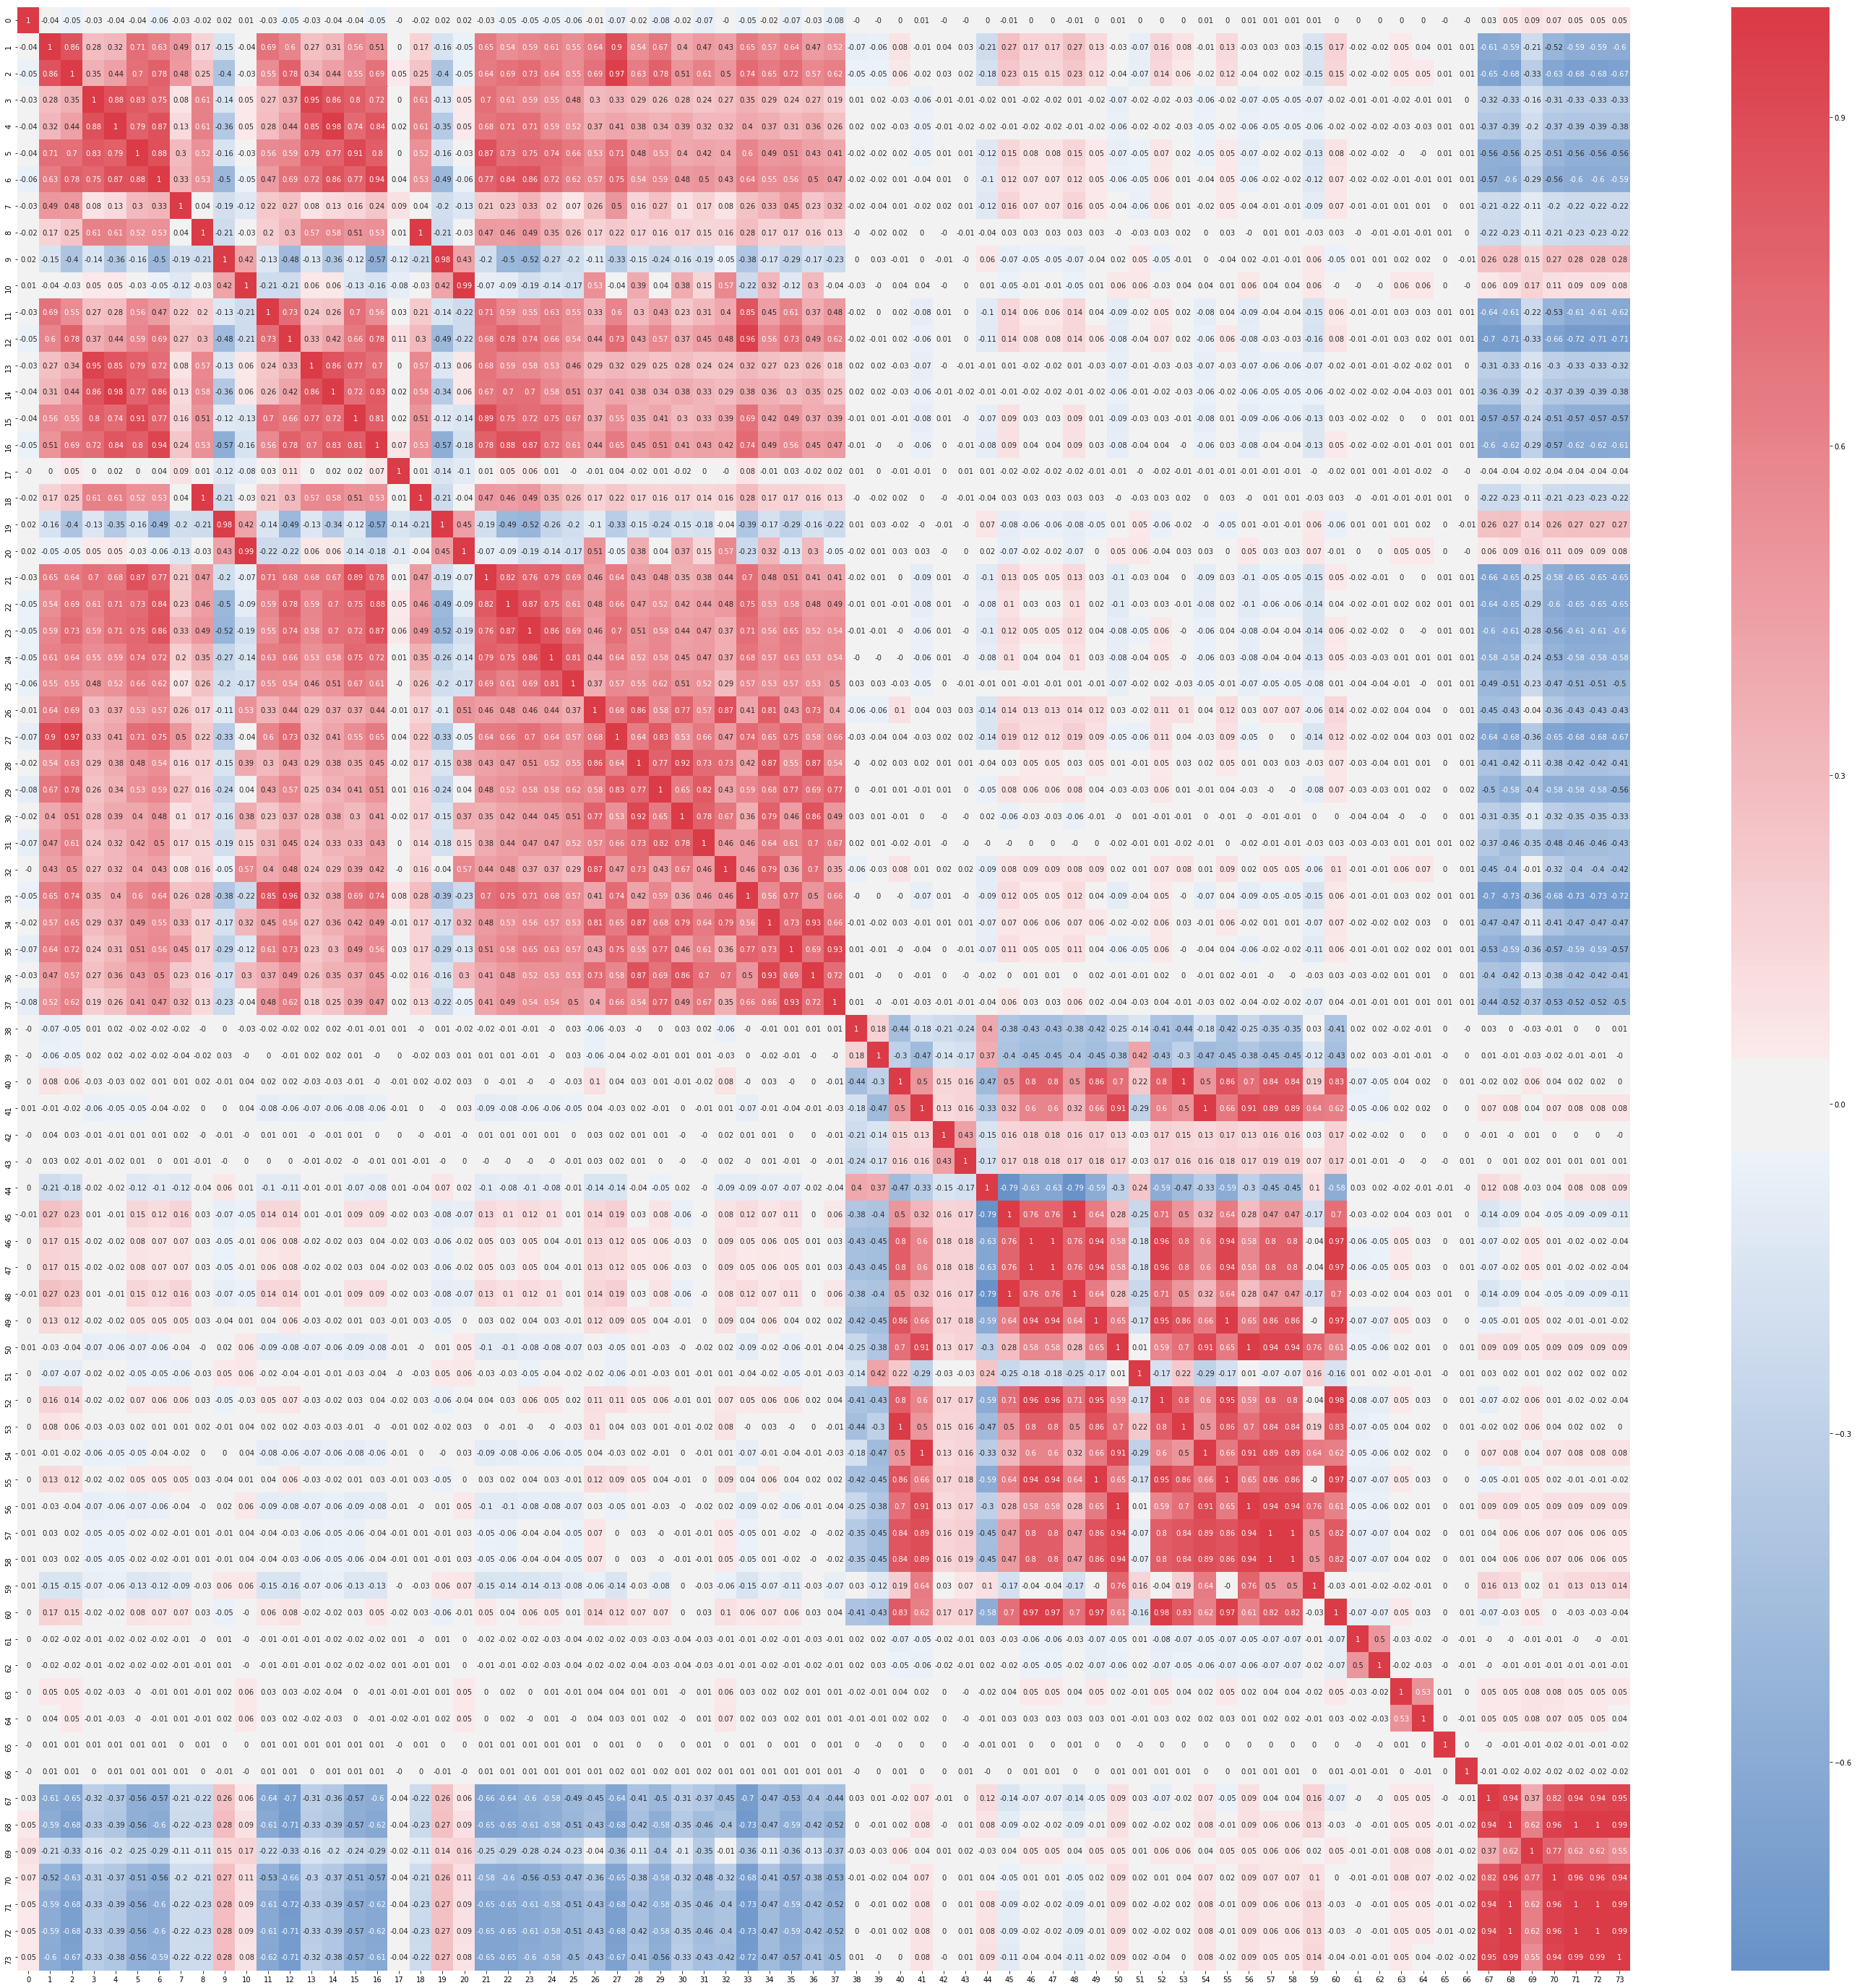

In [39]:
### Corralation matrix heatmap
# Getting correlation matrix
cor_matrix = pd.DataFrame(np.hstack((train_groupe_1 ,train_groupe_2 ,train_groupe_3,train_groupe_4,train_groupe_5))).corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(50,50));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=5, max_features=10, n_jobs=-1, random_state=0)
rf.fit(X_train,Y)
features = np.concatenate((train_groupe_1.columns.values ,train_groupe_2.columns.values ,train_groupe_3.columns.values,train_groupe_4.columns.values,train_groupe_5.columns.values))
print("----- Training Done -----Printing Score")
print(rf.score(X_train,Y))
# Scatter plot 
fi(rf,'Random Forest')

----- Training Done -----Printing Score
0.942072409488


In [41]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=10, min_samples_leaf=5, max_features=10, random_state=0)
gb.fit(X_train,Y)
print("----- Training Done -----Printing Score")
print(gb.score(X_train,Y))
fi(gb,'Gradient Boosting Machine')

----- Training Done -----Printing Score
0.990411985019


In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=5, max_features=10, n_jobs=-1, random_state=0)
rf.fit(X_train_all,Y)
features = np.concatenate((train_groupe_1.columns.values ,train_groupe_2.columns.values ,train_groupe_3.columns.values,train_groupe_4.columns.values,C_train.columns.values))
print("----- Training Done -----Printing Score")
print(rf.score(X_train_all,Y))
# Scatter plot 
fi(rf,'Random Forest')

----- Training Done -----Printing Score
0.941036204744


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=10, min_samples_leaf=5, max_features=10, random_state=0)
gb.fit(X_train_all,Y)
print("----- Training Done -----Printing Score")
print(gb.score(X_train_all,Y))
fi(gb,'Gradient Boosting Machine')

----- Training Done -----Printing Score
0.992634207241


In [ ]:
print('NLP features test')
simple_test(train_groupe_1)
print('---------')
print('Structural features test')
simple_test(train_groupe_2)
print('---------')
simple_test(train_groupe_3)
print('---------')
simple_test(train_groupe_4)
print('---------')
print('Embeded features test')
simple_test(train_groupe_5)
print('---------')
print('All features test')
simple_test(X_train)
print('---------')
print('Augmented features test')
simple_test(X_train_all)
print('---------')

NLP features test
[0]	train-logloss:0.685112	valid-logloss:0.685093
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.462137	valid-logloss:0.461527
[200]	train-logloss:0.441962	valid-logloss:0.442673
[300]	train-logloss:0.433345	valid-logloss:0.435949
---------
Structural features test
[0]	train-logloss:0.681964	valid-logloss:0.681933
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.362547	valid-logloss:0.361428
[200]	train-logloss:0.339882	valid-logloss:0.339093
[300]	train-logloss:0.336417	valid-logloss:0.336407
---------
[0]	train-logloss:0.679325	valid-logloss:0.679392
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.

## 3 - Algorithm and classifiers

In [ ]:
#Some functions and losses for the algorithms

def logloss_lgbm(preds, dtrain):
    labels = dtrain.get_label()
    score = 1-log_loss(labels, preds)
    return 'logloss', score,True

def logloss_xgb(preds, dtrain):
    labels = dtrain.get_label()
    score = log_loss(labels, preds)
    return 'logloss', score

def s(y_pred,i):
    with open("pred/pre"+str(i)+".csv", 'w') as f:
        f.write("Id,Score\n")
        for i in range(len(y_pred)):
            f.write(str(i)+','+str(y_pred[i][1])+'\n')

In [ ]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
######################################################


### LGB modeling
params = {'learning_rate': 0.015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 6,
          'num_leaves': 25,        
          'min_data_in_leaf': 15, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}

params1 = {'learning_rate': 0.015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 7,
          'num_leaves': 25,        
          'min_data_in_leaf': 15, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}
MAX_TREES = 5000

class Classifier1(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        watchlist = [(lgb.Dataset(x1, label=y1), 'train'), (lgb.Dataset(x2, label=y2), 'valid')]
        self.clf2 = lgb.train(params, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
        self.clf1 = lgb.train(params1, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
    def predict(self, X):
        return self.clf1.predict(X)

    def predict_proba(self, X):
        res1 = self.clf1.predict(X, num_iteration = self.clf1.best_iteration)
        res2 = self.clf2.predict(X,num_iteration = self.clf2.best_iteration)
        return [[1-0.5*(a+b),0.5*(a+b)] for a,b in zip(res1,res2)]
        
    
classifier1 = Classifier1()
classifier1.fit(X_train,Y)
pred = classifier1.predict_proba(X_test)
s(pred,1)
pred = classifier1.predict_proba(X_train)
s(pred,2)

In [ ]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
######################################################


### LGB modeling
params = {'learning_rate': 0.01,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 5,
          'num_leaves': 20,        
          'min_data_in_leaf': 30, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}

params1 = {'learning_rate': 0.01,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 6,
          'num_leaves': 20,        
          'min_data_in_leaf': 150, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}
MAX_TREES = 5000

class Classifier1(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        watchlist = [(lgb.Dataset(x1, label=y1), 'train'), (lgb.Dataset(x2, label=y2), 'valid')]
        self.clf2 = lgb.train(params, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
        self.clf1 = lgb.train(params1, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
    def predict(self, X):
        return self.clf1.predict(X)

    def predict_proba(self, X):
        res1 = self.clf1.predict(X, num_iteration = self.clf1.best_iteration)
        res2 = self.clf2.predict(X,num_iteration = self.clf2.best_iteration)
        return [[1-0.5*(a+b),0.5*(a+b)] for a,b in zip(res1,res2)]



classifier1 = Classifier1()
classifier1.fit(X_train_all,Y)
pred = classifier1.predict_proba(X_test_all)
s(pred,3)
pred = classifier1.predict_proba(X_train_all)
s(pred,4)

In [ ]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.02,
          'max_depth': 9, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':15,
          'alpha':2,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.02,
          'max_depth': 8, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':15,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier2(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [(r1+r2)*0.5 for r1,r2 in zip(res1,res2)]
        return np.array([ [1-c,c] for c in res])
    
classifier2 = Classifier2()
classifier2.fit(X_train,Y)
pred = classifier2.predict_proba(X_test)
s(pred,5)
pred = classifier2.predict_proba(X_train)
s(pred,6)

In [ ]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.02,
          'max_depth': 15, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':15,
          'alpha':2,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.02,
          'max_depth': 20, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':15,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier2(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=100)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=100)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [(r1+r2)*0.5 for r1,r2 in zip(res1,res2)]
        return np.array([ [1-c,c] for c in res])
    
classifier2 = Classifier2()
classifier2.fit(X_train_all,Y)
pred = classifier2.predict_proba(X_test_all)
s(pred,7)
pred = classifier2.predict_proba(X_train_all)
s(pred,8)

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

class Classifier3(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        self.clf1 = CatBoostClassifier(iterations=2000,learning_rate=0.02, depth=5, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf1.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
        self.clf2 = CatBoostClassifier(iterations=2000,learning_rate=0.02, depth=6, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf2.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return [[0,(v[1]+l[1])*0.5] for v,l in zip(self.clf2.predict_proba(X),self.clf1.predict_proba(X))]

classifier3 = Classifier3()
classifier3.fit(X_train,Y)
pred = classifier3.predict_proba(X_test)
s(pred,9)
pred = classifier3.predict_proba(X_train)
s(pred,10)

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

class Classifier3(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        self.clf1 = CatBoostClassifier(iterations=2000,learning_rate=0.2, depth=5, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf1.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
        self.clf2 = CatBoostClassifier(iterations=2000,learning_rate=0.2, depth=6, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf2.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return [[0,(v[1]+l[1])*0.5] for v,l in zip(self.clf2.predict_proba(X),self.clf1.predict_proba(X))]

classifier3 = Classifier3()
classifier3.fit(X_train_all,Y)
pred = classifier3.predict_proba(X_test_all)
s(pred,11)
pred = classifier3.predict_proba(X_train_all)
s(pred,12)

In [ ]:
NUM_MODELS = 6
df = pd.read_csv("submission_file.csv")
print(df.head())
for i in range(1, NUM_MODELS):
    df["Score_"+str(i)] = pd.read_csv("pred/pred" + str(2*i+1) + ".csv")["Score"]
df=df.drop(["Score"],axis=1)

X = df.values

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.25, random_state=42)
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100) 

res = bst.predict(xgb.DMatrix(X), ntree_limit=best.best_ntree_limit)
pred = np.array([ [1-c,c] for c in res])
s(pred,13)

In [ ]:
from collections import defaultdict

NUM_MODELS = 6
REPEAT = 2
DUP_THRESHOLD = 0.5
NOT_DUP_THRESHOLD = 0.1
MAX_UPDATE = 0.2
DUP_UPPER_BOUND = 0.98
NOT_DUP_LOWER_BOUND = 0.01

df_train = pd.read_csv("data/train.csv",names =["id", "qid1", "qid2", "question1", "question2", "labels"])
df_test = pd.read_csv("data/test.csv",names =["test_id", "qid1", "qid2", "question1", "question2"])

print("Average Ensembling...")
df = pd.read_csv("submission_file.csv")
print(df.head())
for i in range(1, NUM_MODELS):
    x = pd.read_csv("pred/pred" + str(2*i+1) + ".csv")["Score"]
    l = bst.predict(xgb.DMatrix(x.values), ntree_limit=best.best_ntree_limit)
    df["Score"] = df["Score"] +x+l
df["Score"] =df["Score"].map(lambda x: float(x)/ (2*NUM_MODELS))


test_label = np.array(df["Score"])

print("Updating the predictions of the pairs with common duplicates..")
for i in range(REPEAT):
    dup_neighbors = defaultdict(set)

    for dup, q1, q2 in zip(df_train["labels"], df_train["question1"], df_train["question2"]):
        if dup:
            dup_neighbors[q1].add(q2)
            dup_neighbors[q2].add(q1)

    for dup, q1, q2 in zip(test_label, df_test["question1"], df_test["question2"]):
        if dup > DUP_THRESHOLD:
            dup_neighbors[q1].add(q2)
            dup_neighbors[q2].add(q1)

    count = 0
    for index, (q1, q2) in enumerate(zip(df_test["question1"], df_test["question2"])):
        dup_neighbor_count = len(dup_neighbors[q1].intersection(dup_neighbors[q2]))
        if dup_neighbor_count > 0 and test_label[index] < DUP_UPPER_BOUND:
            update = min(MAX_UPDATE, (DUP_UPPER_BOUND - test_label[index]) / 2)
            test_label[index] += update
            count += 1

    print("Updated:", count)

print("Updating the predictions of the pairs with common non-duplicates..")
for i in range(REPEAT):
    not_dup_neighbors = defaultdict(set)

    for dup, q1, q2 in zip(df_train["labels"], df_train["question1"], df_train["question2"]):
        if not dup:
            not_dup_neighbors[q1].add(q2)
            not_dup_neighbors[q2].add(q1)

    for dup, q1, q2 in zip(test_label, df_test["question1"], df_test["question2"]):
        if dup < NOT_DUP_THRESHOLD:
            not_dup_neighbors[q1].add(q2)
            not_dup_neighbors[q2].add(q1)

    count = 0
    for index, (q1, q2) in enumerate(zip(df_test["question1"], df_test["question2"])):
        dup_neighbor_count = len(not_dup_neighbors[q1].intersection(not_dup_neighbors[q2]))
        if dup_neighbor_count > 0 and test_label[index] > NOT_DUP_LOWER_BOUND:
            update = min(MAX_UPDATE, (test_label[index] - NOT_DUP_LOWER_BOUND) / 2)
            test_label[index] -= update
            count += 1

    print("Updated:", count)

submission = pd.DataFrame({"id":df_test["test_id"], "Score":test_label})
submission.to_csv("pred/submission.csv", index=False)